In [1]:
import numpy as np
from tqdm import tqdm
import zarr

from matplotlib.collections import LineCollection
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import netCDF4 as nc
import h5py
import random

In [2]:
YG = np.load('inputs/ref/YG.npy')
XG = np.load('inputs/ref/XG.npy')
YC = np.load('inputs/ref/YC.npy')
XC = np.load('inputs/ref/XC.npy')
RF = np.load('inputs/ref/RF.npy')

IMF = nc.Dataset('/data/SO2/SO24/ANDY/SOHI/Data/Models/SOHI/2D/2D_2005_09C.nc')
y1 = np.argmin(abs(IMF['YG'] - YG[0]))
y2 = np.argmin(abs(IMF['YG'] - YG[-1]))
x1 = np.argmin(abs(IMF['XG'] - XG[0]%360))
x2 = np.argmin(abs(IMF['XG'] - XG[-1]%360))

In [65]:
icedraft = h5py.File('/data/SO2/SO24/ANDY/SOHI/Data/Models/SOHI/meta/ICEDRAFT_v8.mat')
icedraft = icedraft['Ice_Map'][y1:y2+1,x1:x2+1]

grid = h5py.File('/data/SO2/SO24/ANDY/SOHI/Data/Models/SOHI/meta/GRID_v8.mat')
bath = -grid['Depth'][:]
bath = bath[y1:y2+1,x1:x2+1] + icedraft
bath2 = bath.copy()
bath[bath==0] = np.nan
bath[bath<-2000] = np.nan

In [4]:
mask = np.load('inputs/ref/TIS_Mask.npy')

In [5]:
np.argmin(abs(XC-(-107.7))), np.argmin(abs(XC-(-107))), np.argmin(abs(YC - -75.06))

(776, 792, 42)

In [6]:
np.argmin(abs(XC-(-106.6))), np.argmin(abs(XC-(-105.85))), np.argmin(abs(YC - -74.88))

(802, 820, 58)

In [7]:
np.argmin(abs(XC-(-105.6)))

826

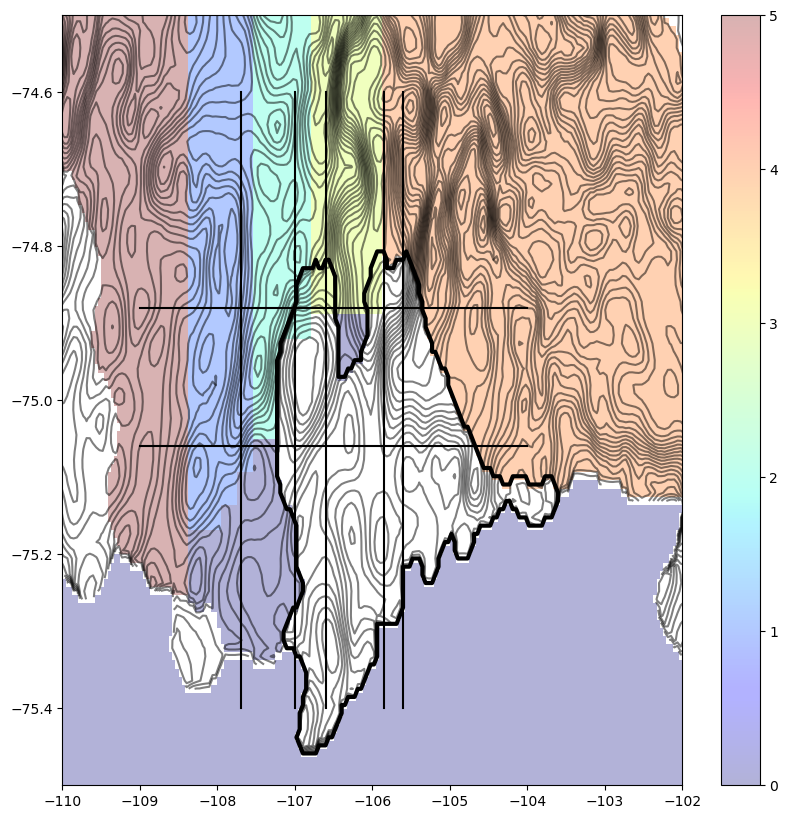

In [88]:
newmask = np.zeros(mask.shape)
newmask[:100, 820:] = 4
newmask[43:, 760:790] = 2
newmask[39:, 755:780] = 1
newmask[35:, 755:775] = 1
newmask[32:, 755:770] = 1
newmask[:100, 700:760] = 5

newmask[icedraft!=0] = np.nan
newmask[58:, 798:820] = 3
newmask[55:, 780:798] = 2
newmask[bath2 == 0] = 0

fig, ax = plt.subplots(figsize=(10,10))


ax.contour(XC, YC, bath, levels=np.arange(-1600, 0, 50), colors=['k'], linestyles='solid', alpha=0.5, zorder=3)

ax.contour(XC, YC, mask, levels=[0,1], colors=['k'], linewidths=3)

im = ax.pcolormesh(XC, YC, newmask, cmap='jet', alpha=0.3)

ax.set_xlim(-110, -102)
ax.set_ylim(-75.5, -74.5)

ax.plot([-106.6, -106.6], [-75.4, -74.6], c='k')
ax.plot([-105.85, -105.85], [-75.4, -74.6], c='k')
ax.plot([-109, -104], [-74.88, -74.88], c='k')

ax.plot([-107.7, -107.7], [-75.4, -74.6], c='k')
ax.plot([-107, -107], [-75.4, -74.6], c='k')
ax.plot([-109, -104], [-75.06, -75.06], c='k')

ax.plot([-105.6, -105.6], [-75.4, -74.6], c='k')

plt.colorbar(im)

In [67]:
## t-index, theta, lon, lat, depth

def get_vals(zarr_path, exit_index_path):
    data = zarr.open(zarr_path, 'r')
    exit = np.load(exit_index_path)
    
    tindex = []
    
    traj_lon = []
    traj_lat = []
    traj_I = []
    traj_J = []
    
    for i in tqdm(range(len(exit))):
        if ~np.isnan(exit[i]):
            
            j = int(exit[i])
            tindex.append(j)
            
            traj_lon.append(data['lon'][i][:j+10])
            traj_lat.append(data['lat'][i][:j+10])
            traj_I.append(data['I'][i][:j+10])
            traj_J.append(data['J'][i][:j+10])
        
    return np.asarray(tindex), np.asarray(traj_lon), np.asarray(traj_lat), np.asarray(traj_I), np.asarray(traj_J)

In [68]:
data = zarr.open('outputs/R8_ASE_5min/thwaites.zarr', 'r')
I = np.asarray(data['I'][:])
J = np.asarray(data['J'][:])
IS = np.load('processed_dataGL/thwaites_0d_IS.npy')
LON = np.asarray(data['lon'][:])
LAT = np.asarray(data['lat'][:])

In [98]:
classification = []
newT = []
count = 0
    
for p in tqdm(range(len(IS))):
    if ~np.isnan(IS[p]):
        added = False
        for t in range(1095):
            ii = int(I[p, t])
            jj = int(J[p, t])
            if newmask[ii, jj] != 0 and ~np.isnan(newmask[ii, jj]):
                classification.append(newmask[ii, jj])
                newT.append(t)
                added = True
                break
            
        if not added:
            classification.append(9)
            newT.append(1095)
            count += 1
                
    else:
        classification.append(np.nan)
        newT.append(np.nan)

classification = np.asarray(classification)
newT = np.asarray(newT)
print(count)

100%|█████████████████████████████████| 389790/389790 [01:42<00:00, 3814.10it/s]

7536


In [90]:
n = np.count_nonzero(~np.isnan(classification))

print(np.count_nonzero(classification == 1)/n*100)
print(np.count_nonzero(classification == 2)/n*100)
print(np.count_nonzero(classification == 3)/n*100)
print(np.count_nonzero(classification == 4)/n*100)
print(np.count_nonzero(classification == 5)/n*100)
print(np.count_nonzero(classification == 9)/n*100)

1.594448719621465
7.951207952006774
3.2935431217431357
85.15389305903561
0.0002662740012727897
2.0066408735917434


In [71]:
tismask = np.load('tis_mask.npy')

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 3452.41it/s]


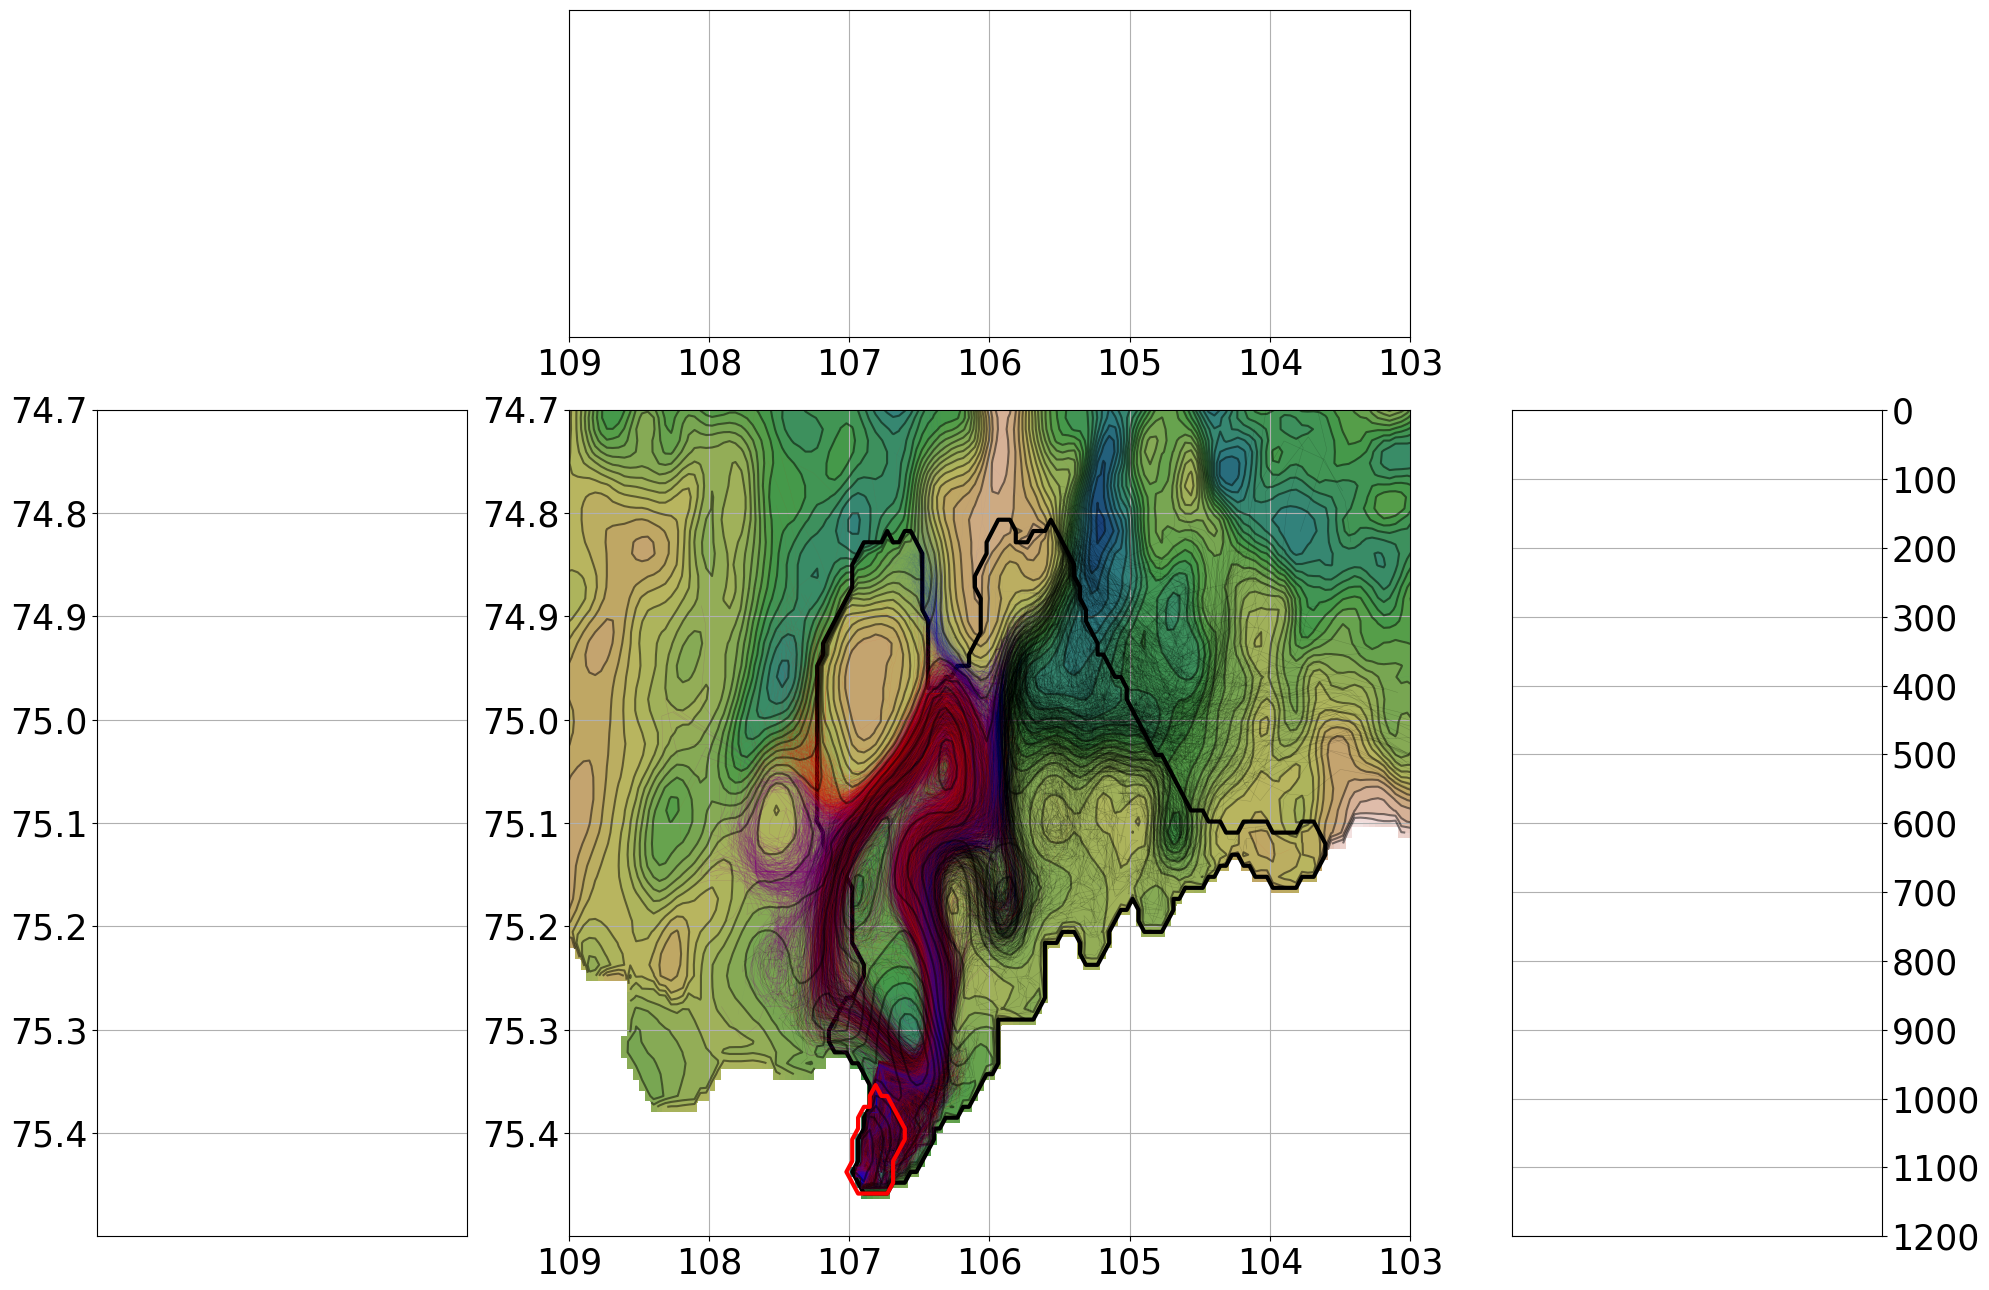

In [75]:
ls = 25
density = True

fig = plt.figure(figsize=(20, 13))

gs = gridspec.GridSpec(13, 16)
ax_main = plt.subplot(gs[4:, 4:12])
ax_xDist = plt.subplot(gs[0:4, 4:12],sharex=ax_main)
ax_yDist = plt.subplot(gs[4:13, :4],sharey=ax_main)
ax_zDist = plt.subplot(gs[4:13, 12:])

## Main Plot
ax_main.pcolormesh(XC, YC, bath, vmin=-1600, vmax= 0, cmap='gist_earth')
ax_main.contourf(XC, YC, bath, levels=np.arange(-1601, 1, 50), cmap='gist_earth')
ax_main.contour(XC, YC, bath, levels=np.arange(-1601, 1, 50), colors=['k'], linestyles='solid', alpha=0.5, zorder=3)
ax_main.contour(XC, YC, mask, levels=[0,1], colors=['k'], linewidths=3)


ax_main.contour(XC, YC, tismask, levels=[0,1], colors=['red'], linewidths=3, zorder=3)

ax_main.set_xticks([-109,-108, -107, -106, -105, -104, -103, -102])
ax_main.set_xticklabels([109, 108, 107, 106, 105, 104, 103, 102])

ax_main.set_yticks([-75.4, -75.3, -75.2, -75.1, -75, -74.9, -74.8, -74.7])
ax_main.set_yticklabels([75.4, 75.3, 75.2, 75.1, "75.0", 74.9, 74.8, 74.7])

ax_main.set_xlim(-109, -103)
ax_main.set_ylim(-75.5, -74.7)


ax_main.tick_params(axis='both', labelsize=ls)
ax_main.grid()

###
slon = LON[classification==1]
slat = LAT[classification==1]
st = IS[classification==1]
index = np.random.choice([i for i in range(len(slon))], size=1000, replace=False)


for c in tqdm(range(len(index))):
    
    i = index[c]
    
    try:
        lx = slon[i][:int(st[i]+10)]
    except:
        print(st[i])
    ly = slat[i][:int(st[i]+10)]
    c = np.arange(len(lx))

    ax_main.plot(lx, ly, color='purple', lw=0.3, alpha=0.2)
    
    
###
slon = LON[classification==4]
slat = LAT[classification==4]
st = IS[classification==4]
index = np.random.choice([i for i in range(len(slon))], size=1000, replace=False)


for c in tqdm(range(len(index))):
    
    i = index[c]
    
    try:
        lx = slon[i][:int(st[i]+10)]
    except:
        print(st[i])
    ly = slat[i][:int(st[i]+10)]
    c = np.arange(len(lx))

    ax_main.plot(lx, ly, color='k', lw=0.3, alpha=0.2)
    
###
slon = LON[classification==2]
slat = LAT[classification==2]
st = IS[classification==2]
index = np.random.choice([i for i in range(len(slon))], size=1000, replace=False)


for c in tqdm(range(len(index))):
    
    i = index[c]
    
    try:
        lx = slon[i][:int(st[i]+10)]
    except:
        print(st[i])
    ly = slat[i][:int(st[i]+10)]
    c = np.arange(len(lx))

    ax_main.plot(lx, ly, color='red', lw=0.1, alpha=0.2)
    
    
    
###
slon = LON[classification==3]
slat = LAT[classification==3]
st = IS[classification==3]
index = np.random.choice([i for i in range(len(slon))], size=1000, replace=False)


for c in tqdm(range(len(index))):
    
    i = index[c]
    
    try:
        lx = slon[i][:int(st[i]+10)]
    except:
        print(st[i])
    ly = slat[i][:int(st[i]+10)]
    c = np.arange(len(lx))

    ax_main.plot(lx, ly, color='blue', lw=0.07, alpha=0.1)
    
    

ax_zDist.tick_params(axis='both', labelsize=ls)
ax_zDist.invert_xaxis()
ax_zDist.yaxis.set_label_position("right")
ax_zDist.yaxis.tick_right()
ax_zDist.set_yticks([0, -100, -200, -300, -400, -500, -600, -700, -800, -900, -1000, -1100, -1200])
ax_zDist.set_yticklabels([0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200])
ax_zDist.set_xticks([])
ax_zDist.grid()

ax_yDist.tick_params(axis='both', labelsize=ls)
ax_yDist.set_xticks([])
ax_yDist.grid()

ax_xDist.tick_params(axis='both', labelsize=ls)
ax_xDist.set_yticks([])
ax_xDist.grid()

plt.tight_layout()

plt.savefig('img_cavity_paths/Thwaites_Mod.png', dpi=300)

In [77]:
def calc_cavity_flushing(newT, stucked, filt, IS, filt_val = None):
    data = newT
    stucked = np.load(stucked)
    exit = np.load(IS)
    
    
    n = len(data)
    num = int(n/366)
    
    flush = []
    rates = []
    
    p05 = []
    p50 = []
    p95 = []
    
    for i in tqdm(range(0, n, num)):
        sub = data[i:i+num] ## Particles
        flags = stucked[i:i+num] ## Stucked particles in cavity

        if filt is None:
            sf = np.asarray([1 for _ in range(len(flags))])
            filt_val = 1
        else:
            sf = filt[i:i+num]
            sf[sf==4]
            
        ## Number of valid particle for analysis
        
        sub = sub[np.logical_and(sf==filt_val, flags==0)]

        n_sub = len(sub) ## Only particles of interest 
        n_tot = np.count_nonzero(np.logical_and(~np.isnan(sf), flags==0)) ## All particles that exited 
        
        p05.append(np.nanpercentile(sub, 5)) ## Percentile of particles of interest
        p50.append(np.nanpercentile(sub, 50))
        p95.append(np.nanpercentile(sub, 99))
    
        hist, _ = np.histogram(sub, np.arange(0,1100,1))
        exit_percent = np.asarray(np.cumsum(hist) / n_tot * 100) ## % of total particles
        f = np.asarray([v for v in exit_percent])
        r = np.asarray([np.count_nonzero(sub==v) for v in np.arange(0, 1095, 1)])
        
        if n_sub !=0: 
            r = r/n_sub*100
        else: ## If particles of interest is zero, then there's 0 rate
            r = 0
        
        rates.append(r)
        flush.append(f)
    
    print(f"Fastest 5% = {np.nanmean(p05)} +- {np.nanstd(p05)}")
    print(f"Median = {np.nanmean(p50)} +- {np.nanstd(p50)}")
    print(f"Slowest 5% = {np.nanmean(p95)} +- {np.nanstd(p95)}")
    
    return np.asarray(flush), np.asarray(rates)

In [113]:
flush1, rate1 = calc_cavity_flushing(newT=newT,
                   stucked = 'processed_dataGL/thwaites_0d_Stucked_incavity.npy',
                filt = classification,
                IS = 'processed_dataGL/thwaites_0d_IS.npy',
                filt_val = 1)

flush2, rate2 = calc_cavity_flushing(newT=newT,
                   stucked = 'processed_dataGL/thwaites_0d_Stucked_incavity.npy',
                filt = classification,
                IS = 'processed_dataGL/thwaites_0d_IS.npy',
                filt_val = 2)

flush3, rate3 = calc_cavity_flushing(newT=newT,
                   stucked = 'processed_dataGL/thwaites_0d_Stucked_incavity.npy',
                filt = classification,
                IS = 'processed_dataGL/thwaites_0d_IS.npy',
                filt_val = 3)

flush4, rate4 = calc_cavity_flushing(newT=newT,
                   stucked = 'processed_dataGL/thwaites_0d_Stucked_incavity.npy',
                filt = classification,
                IS = 'processed_dataGL/thwaites_0d_IS.npy',
                filt_val = 4)

100%|████████████████████████████████████████| 366/366 [00:01<00:00, 302.72it/s]


Fastest 5% = 39.4542349726776 +- 15.881775128912205
Median = 71.54098360655738 +- 30.196324155021603
Slowest 5% = 224.19904371584698 +- 86.36323130053795


100%|████████████████████████████████████████| 366/366 [00:01<00:00, 300.93it/s]


Fastest 5% = 25.055874316939892 +- 7.742849666426526
Median = 60.372950819672134 +- 27.416208271606724
Slowest 5% = 270.90647540983605 +- 71.93640923132308


100%|████████████████████████████████████████| 366/366 [00:01<00:00, 302.31it/s]


Fastest 5% = 30.947540983606554 +- 23.408536273248068
Median = 62.83606557377049 +- 44.00306322963582
Slowest 5% = 231.98297814207646 +- 77.94923913749432


100%|████████████████████████████████████████| 366/366 [00:01<00:00, 264.19it/s]


Fastest 5% = 24.476775956284154 +- 4.45552324870489
Median = 66.26229508196721 +- 13.296566760964035
Slowest 5% = 318.39923497267756 +- 29.422321652728044


100%|████████████████████████████████████████| 366/366 [00:01<00:00, 303.31it/s]

Fastest 5% = 1095.0 +- 0.0
Median = 1095.0 +- 0.0
Slowest 5% = 1095.0 +- 0.0


In [85]:
rmean1 = np.mean(rate1, axis=0)
rstd1 = np.std(rate1, axis=0)
fmean1 = np.mean(flush1, axis=0)
fstd1 = np.std(flush1, axis=0)

print(f'% of total particles that exited: {fmean1[-1]} +- {fstd1[-1]}')

rmean2 = np.mean(rate2, axis=0)
rstd2 = np.std(rate2, axis=0)
fmean2 = np.mean(flush2, axis=0)
fstd2 = np.std(flush2, axis=0)

print(f'% of total particles that exited: {fmean2[-1]} +- {fstd2[-1]}')

rmean3 = np.mean(rate3, axis=0)
rstd3 = np.std(rate3, axis=0)
fmean3 = np.mean(flush3, axis=0)
fstd3 = np.std(flush3, axis=0)

print(f'% of total particles that exited: {fmean3[-1]} +- {fstd3[-1]}')

rmean4 = np.mean(rate4, axis=0)
rstd4 = np.std(rate4, axis=0)
fmean4 = np.mean(flush4, axis=0)
fstd4 = np.std(flush4, axis=0)

print(f'% of total particles that exited: {fmean4[-1]} +- {fstd4[-1]}')


rmean4 = np.mean(rate4, axis=0)
rstd4 = np.std(rate4, axis=0)
fmean4 = np.mean(flush4, axis=0)
fstd4 = np.std(flush4, axis=0)

print(f'% of total particles that exited: {fmean4[-1]} +- {fstd4[-1]}')

% of total particles that exited: 1.5936084361398826 +- 0.8436611079339009
% of total particles that exited: 7.9560580966902545 +- 4.460118029700307
% of total particles that exited: 3.2945409219563637 +- 2.407244428220592
% of total particles that exited: 85.14850248301053 +- 7.043970096511533


### Count Loop

In [99]:
len(classification), len(newT)

(389790, 389790)

In [100]:
nloop = []
cooldown = 1

for p in tqdm(range(len(classification))):
    counter = 0
    tracker = 0
    if np.isnan(newT[p]):
        nloop.append(np.nan)
        continue
        
    else: 
        inside = True
        outside = False 
        
        if classification[p] !=9:
            maxval = int(newT[p])
        else:
            maxval = 1095
            
        for t in range(maxval):
            i = int(I[p, t])
            j = int(J[p, t])
            
            if inside:
                if newmask[i, j] == 0:
                    inside = False 
                    outside = True
                else:
                    continue
            elif outside:
                if newmask[i,j] == 0:
                    counter += 1
                else:
                    inside = True
                    outside = False 
                    
            
                    if counter > cooldown:
                        tracker += 1
                        counter = 0

        nloop.append(tracker)
        
nloop = np.asarray(nloop)
                    
            

100%|████████████████████████████████| 389790/389790 [00:35<00:00, 10879.76it/s]


In [101]:
n = np.count_nonzero(~np.isnan(nloop))

In [102]:
print(f"perc of particles looping at least once: {np.count_nonzero(nloop >= 1)/n*100}%")
print(f"perc of particles looping 0x: {np.count_nonzero(nloop == 0)/n*100}%")
print(f"perc of particles looping 1x: {np.count_nonzero(nloop == 1)/n*100}%")
print(f"perc of particles looping 2x: {np.count_nonzero(nloop == 2)/n*100}%")
print(f"perc of particles looping 3x: {np.count_nonzero(nloop == 3)/n*100}%")
print(f"perc of particles looping 4x: {np.count_nonzero(nloop == 4)/n*100}%")
print(f"perc of particles looping 5x: {np.count_nonzero(nloop == 5)/n*100}%")
print(f"perc of particles looping 6x: {np.count_nonzero(nloop == 6)/n*100}%")

perc of particles looping at least once: 44.90817541066108%
perc of particles looping 0x: 55.09182458933892%
perc of particles looping 1x: 22.33399813075651%
perc of particles looping 2x: 10.281904285147503%
perc of particles looping 3x: 5.2767518832228735%
perc of particles looping 4x: 2.926617547989232%
perc of particles looping 5x: 1.6722007279931193%
perc of particles looping 6x: 0.9644444326100444%


In [104]:
print(f"perc of particles looping 6x: {np.count_nonzero(nloop >= 6)/n*100}%")

perc of particles looping 6x: 2.4167028355518396%


In [105]:
sub1 = nloop[classification==1]
nn = np.count_nonzero(~np.isnan(sub1))
p1 = [np.count_nonzero(sub1 == i)/nn*100 for i in range(10) ]

In [106]:
sub2 = nloop[classification==2]
nn = np.count_nonzero(~np.isnan(sub2))
p2 = [np.count_nonzero(sub2 == i)/nn*100 for i in range(10) ]

In [107]:
sub3 = nloop[classification==3]
nn = np.count_nonzero(~np.isnan(sub3))
p3 = [np.count_nonzero(sub3 == i)/nn*100 for i in range(10) ]

In [108]:
sub4 = nloop[classification==4]
nn = np.count_nonzero(~np.isnan(sub4))
p4 = [np.count_nonzero(sub4 == i)/nn*100 for i in range(10) ]

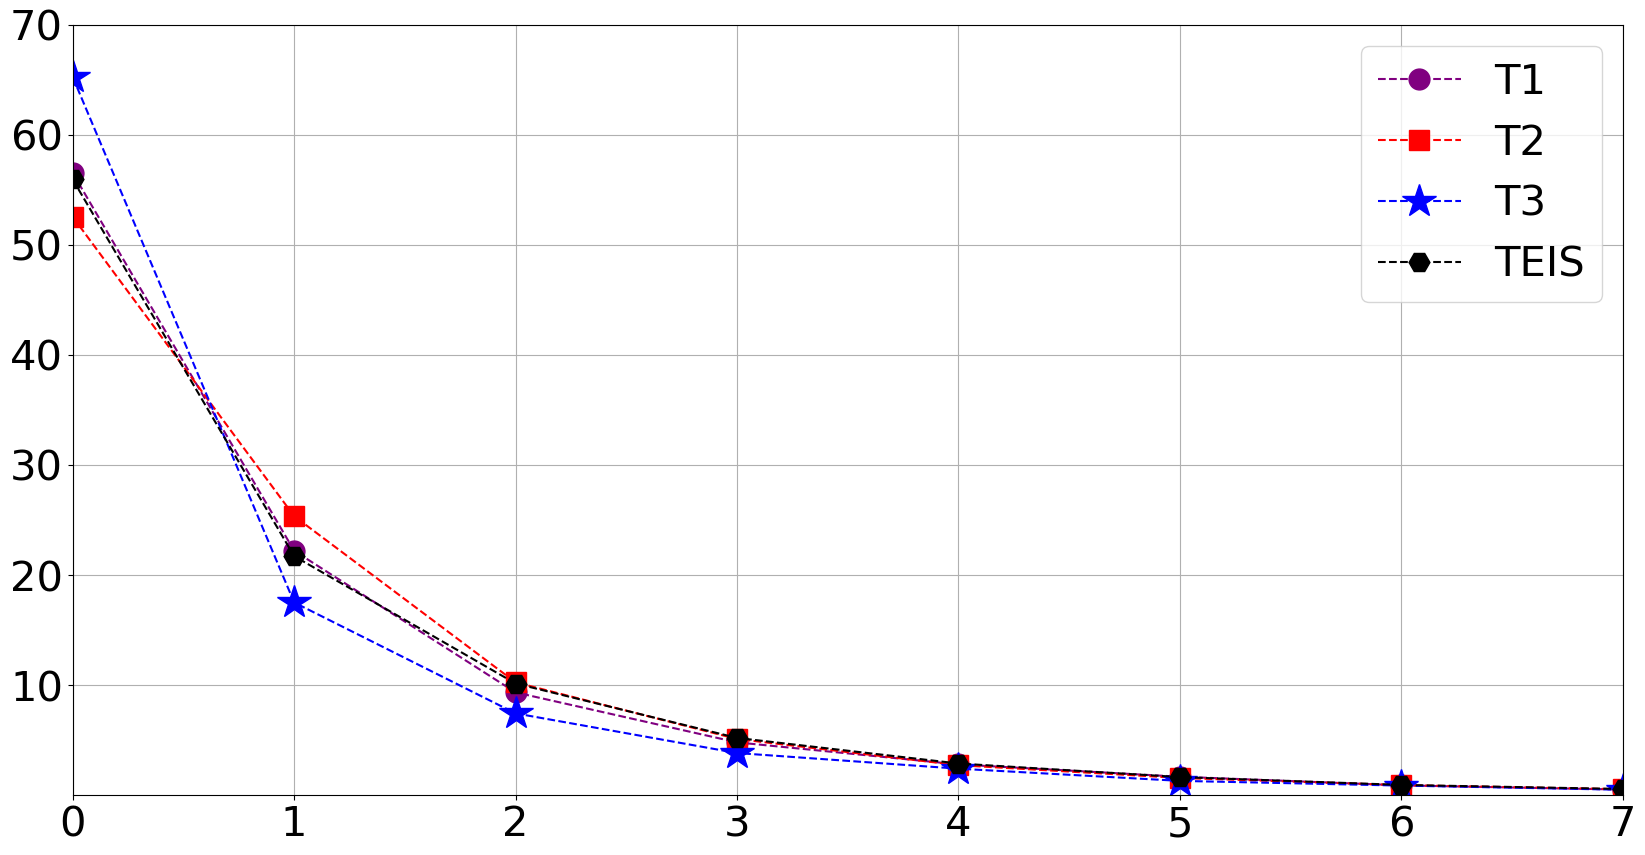

In [112]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(np.arange(10), p1,'--', marker='o', color='purple', ms=15, label='T1')
ax.plot(np.arange(10), p2, '--', marker='s', color='red', ms=15, label ='T2')
ax.plot(np.arange(10), p3, '--', marker='*', color='blue', ms=25, label = 'T3')
ax.plot(np.arange(10), p4, '--', marker='H', color='k', ms=15, label = 'TEIS')


ax.grid()
ax.set_ylim(0, 70)
ax.set_xlim(0,7)

ax.set_xticks([0,1,2,3,4,5,6,7])
ax.set_yticks([10, 20, 30, 40, 50, 60, 70])

ax.tick_params(labelsize=30)

ax.legend(fontsize=30)


plt.savefig('img_cavity_paths/Thwaites_nloop.png', dpi=300)